## Импорт библиотек и объявление констант

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split



from sklearn.preprocessing import (StandardScaler,
                                   OrdinalEncoder,
                                   OneHotEncoder)


from sklearn.linear_model import LogisticRegression


from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.metrics import (make_scorer,
                             roc_auc_score
                            )
from sklearn.preprocessing import FunctionTransformer



import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


from sklearn.dummy import DummyRegressor


TEST_SIZE = 0.2
RANDOM_STATE = 666

In [2]:
# import sys
# !{sys.executable} -m pip freeze > requirements.txt


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format','{:.4f}'.format)

custom_palette = [
    '#2A5CAA',  # глубокий синий
    '#E63946',  # яркий красный
    '#8B0000',  # тёмно-красный   
    '#457B9D',  # мягкий сине-бирюзовый
    '#A8DADC',  # нежный бирюзовый
    '#F1FAEE',  # молочный белый
    '#B53844',  # глиняный тёплый красный
    '#3A3A3A'   # глубокий графит
]




sns.set_palette(custom_palette)

## Загрузка данных

In [4]:
messages = pd.read_csv('filtered_data/apparel-messages.csv',parse_dates=['date','created_at'])
purchases = pd.read_csv('filtered_data/apparel-purchases.csv',parse_dates=['date'])
target = pd.read_csv('filtered_data/apparel-target_binary.csv')
daily_event_1 = pd.read_csv('filtered_data/full_campaign_daily_event_channel.csv',parse_dates=['date'])
daily_event_2 = pd.read_csv('filtered_data/full_campaign_daily_event.csv',parse_dates=['date'])

### Ознакомление с данными

In [5]:
messages.head(10)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
5,4439,1515915625594606468,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19,2022-05-19 01:04:11
6,4439,1515915625491810918,1515915625491810918-4439-6283411d9d299,open,email,2022-05-19,2022-05-19 01:19:54
7,4439,1515915625474219766,1515915625474219766-4439-628341212233a,open,email,2022-05-19,2022-05-19 01:23:43
8,4439,1515915625474219766,1515915625474219766-4439-628341212233a,click,email,2022-05-19,2022-05-19 01:24:16
9,4439,1515915625566741491,1515915625566741491-4439-6283412871599,open,email,2022-05-19,2022-05-19 01:31:06


In [6]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


In [7]:
purchases.head(10)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0000,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0000,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0000,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0000,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0000,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
5,1515915625471640575,1,3499.0000,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3
6,1515915625490211585,1,1699.0000,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283
7,1515915625490739153,1,1999.0000,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b
8,1515915625491478747,1,999.0000,"['5562', '5631', '5549', '667']",2022-05-16,1515915625491478747-4273-6274ceb769d59
9,1515915625491651493,1,699.0000,"['5562', '5630', '5649', '678']",2022-05-16,1515915625491651493-4437-6282242f2a9e2


In [8]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


In [9]:
target.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [10]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [11]:
daily_event_1.head()

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,nunique_click_email,nunique_click_mobile_push,nunique_open_email,nunique_open_mobile_push,nunique_purchase_email,nunique_purchase_mobile_push,nunique_soft_bounce_email,nunique_subscribe_email,nunique_unsubscribe_email,count_hard_bounce_mobile_push,count_send_mobile_push,nunique_hard_bounce_mobile_push,nunique_send_mobile_push,count_hard_bounce_email,count_hbq_spam_email,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
daily_event_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   date                             131072 non-null  datetime64[ns]
 1   bulk_campaign_id                 131072 non-null  int64         
 2   count_click_email                131072 non-null  int64         
 3   count_click_mobile_push          131072 non-null  int64         
 4   count_open_email                 131072 non-null  int64         
 5   count_open_mobile_push           131072 non-null  int64         
 6   count_purchase_email             131072 non-null  int64         
 7   count_purchase_mobile_push       131072 non-null  int64         
 8   count_soft_bounce_email          131072 non-null  int64         
 9   count_subscribe_email            131072 non-null  int64         
 10  count_unsubscribe_email          131072 non-

In [13]:
daily_event_2.head()

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,nunique_click,nunique_complain,nunique_hard_bounce,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [14]:
daily_event_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 131072 non-null  datetime64[ns]
 1   bulk_campaign_id     131072 non-null  int64         
 2   count_click          131072 non-null  int64         
 3   count_complain       131072 non-null  int64         
 4   count_hard_bounce    131072 non-null  int64         
 5   count_open           131072 non-null  int64         
 6   count_purchase       131072 non-null  int64         
 7   count_send           131072 non-null  int64         
 8   count_soft_bounce    131072 non-null  int64         
 9   count_subscribe      131072 non-null  int64         
 10  count_unsubscribe    131072 non-null  int64         
 11  nunique_click        131072 non-null  int64         
 12  nunique_complain     131072 non-null  int64         
 13  nunique_hard_b

### Промежуточный вывод после ознакомления с данными
* Названия столбцов стилистически корректны
* Пропуски отсутствуют
* Даты были сразу преобразованы из строкового формата в datetime



## Создание единого датасета

In [15]:
# объединение
df = purchases.merge(
    messages,
    on=['client_id', 'message_id'],
    how='inner').merge(target, on='client_id', how='inner')
df = df.rename(columns={'date_x': 'date_purchase', 'date_y': 'date_message'})

df.shape

(805820, 12)

In [16]:
df.head()

,client_id,quantity,price,category_ids,date_purchase,message_id,bulk_campaign_id,event,channel,date_message,created_at,target
0,1515915625490739153,1,1999.0000,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b,4172,open,email,2022-05-27,2022-05-27 07:52:08,0
1,1515915625491869271,2,599.0000,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,2090,click,email,2023-04-12,2023-04-12 08:25:33,0
2,1515915625491869271,2,599.0000,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,2090,click,email,2023-04-18,2023-04-18 11:47:45,0
3,1515915625491869271,2,599.0000,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,2090,click,email,2023-06-13,2023-06-13 11:10:41,0
4,1515915625491869271,2,599.0000,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,2090,click,email,2023-12-28,2023-12-28 11:25:50,0


## Предобработка данных

In [17]:
# Создадим из категорий множества
df['cat_set'] = df['category_ids'].apply(frozenset)
# каждому множеству присвоим номер
codes, uniques = pd.factorize(df['cat_set'])
df['cat_id'] = codes
df = df.drop(columns='cat_set')
len(df['cat_id'].unique())

244

In [18]:
dups = df[df.duplicated(keep=False)]
print(len(dups))
dups.sort_values(by=df.columns.tolist()).head()


521154


,client_id,quantity,price,category_ids,date_purchase,message_id,bulk_campaign_id,event,channel,date_message,created_at,target,cat_id
15633,1515915625468060902,1,199.0000,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196,4617,click,email,2022-05-27,2022-05-27 10:59:04,0,116
15677,1515915625468060902,1,199.0000,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196,4617,click,email,2022-05-27,2022-05-27 10:59:04,0,116
15634,1515915625468060902,1,199.0000,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196,4617,click,email,2022-05-27,2022-05-27 11:22:53,0,116
15678,1515915625468060902,1,199.0000,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196,4617,click,email,2022-05-27,2022-05-27 11:22:53,0,116
15637,1515915625468060902,1,199.0000,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196,4617,click,email,2022-05-27,2022-05-27 11:35:07,0,116


*Это явные дубликаты, вплоть до секунды в столбце created_at, можно удалить*

In [19]:
df = df.drop_duplicates()

## EDA

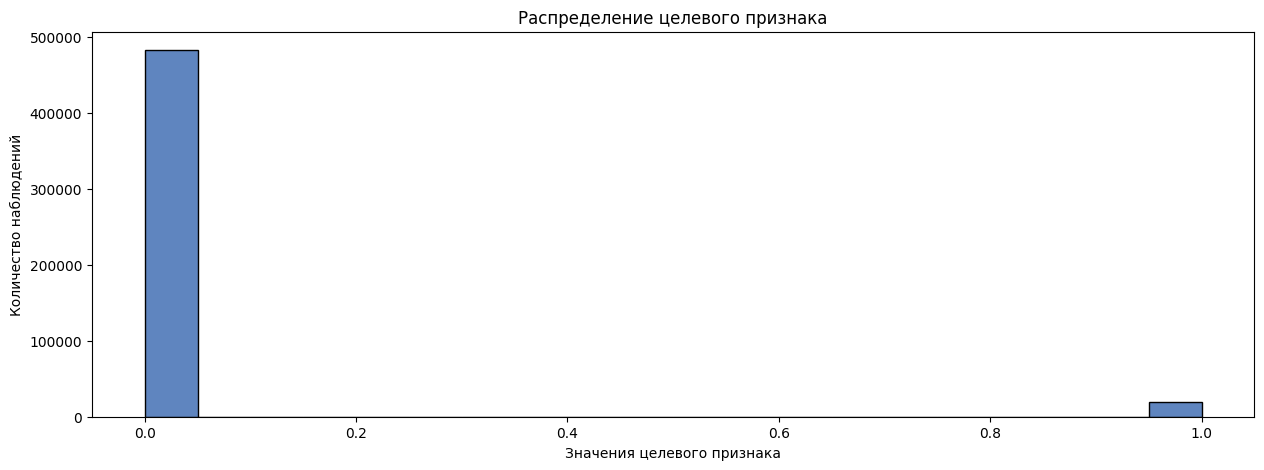

In [20]:
# Распределение таргета
plt.figure(figsize=(15,5))
sns.histplot(df['target'])
plt.title('Распределение целевого признака')
plt.xlabel('Значения целевого признака')
plt.ylabel('Количество наблюдений');

In [21]:
df['target'].value_counts()

target
0    482998
1     19127
Name: count, dtype: int64

***Биномиальное распредленеие. Сильный дисбаланс классов***

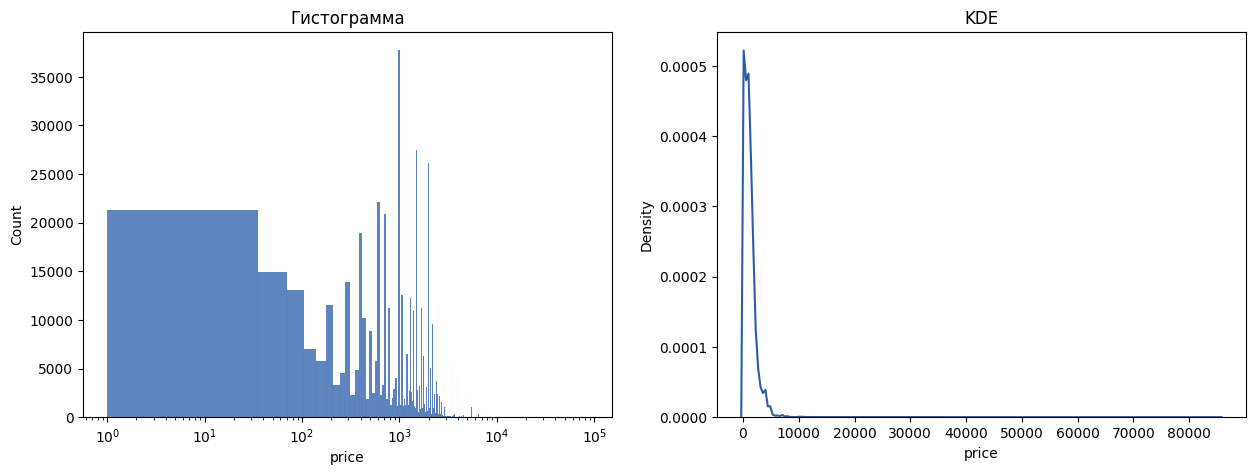

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

sns.histplot(df['price'], ax=axes[0])
axes[0].set_xscale('log')
axes[0].set_title("Гистограмма")

sns.kdeplot(df['price'], ax=axes[1])
axes[1].set_title("KDE")
axes[1].set_xticks(np.arange(0, 90_000, 10_000))
plt.show()


***Распределение с тяжелым хвостом справа. Большинство покупок в ценовом диапазоне до 100 рублей. В диапазоне от 100 до 1000 рублей на гистограмме видно множество шипов, это либо стандартные цены на популярные товары, либо округление цен. Начиная с 10 000 рублей количество покупок резко падает***

In [23]:
df['quantity'].unique()

array([ 1,  2,  3, 25, 13,  4, 10, 30, 18,  8, 15,  6,  9,  5,  7])

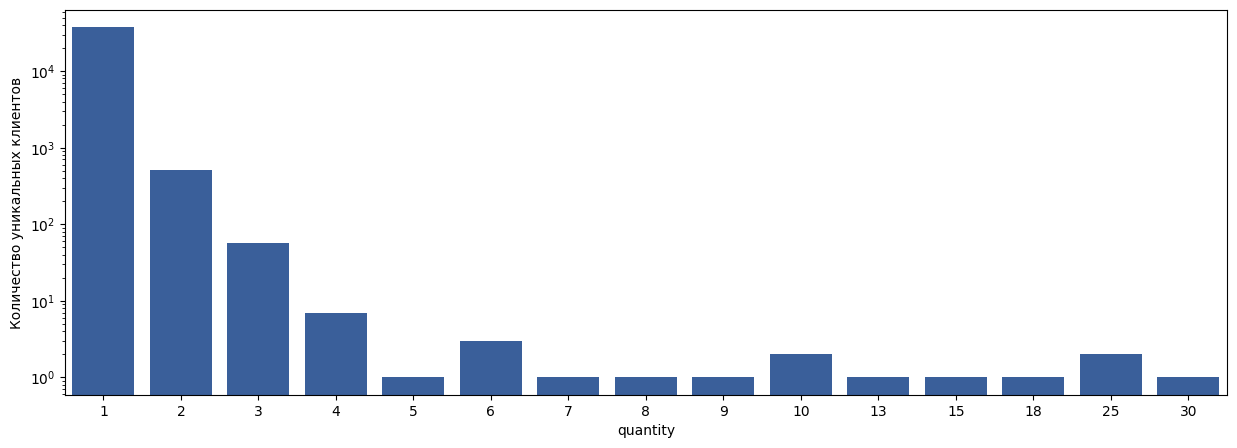

In [24]:
plt.figure(figsize=(15,5))
client_counts = df.groupby('quantity')['client_id'].nunique()
sns.barplot(
    data=client_counts.reset_index(),
    x='quantity', y='client_id'
)
plt.ylabel("Количество уникальных клиентов")
plt.yscale('log')
plt.show()

***чаще всего люди заказывают по одной единице товара***

In [25]:
len(df['bulk_campaign_id'].unique())

1526

***Всего было проведено 1526 рекламных кампаний***

In [26]:
target_stats = (
    df.groupby('bulk_campaign_id')['target']
      .agg(['mean', 'sum', 'count'])
      .rename(columns={
          'mean': 'success_rate',
          'sum': 'num_success',
          'count': 'total_records'
      })
)

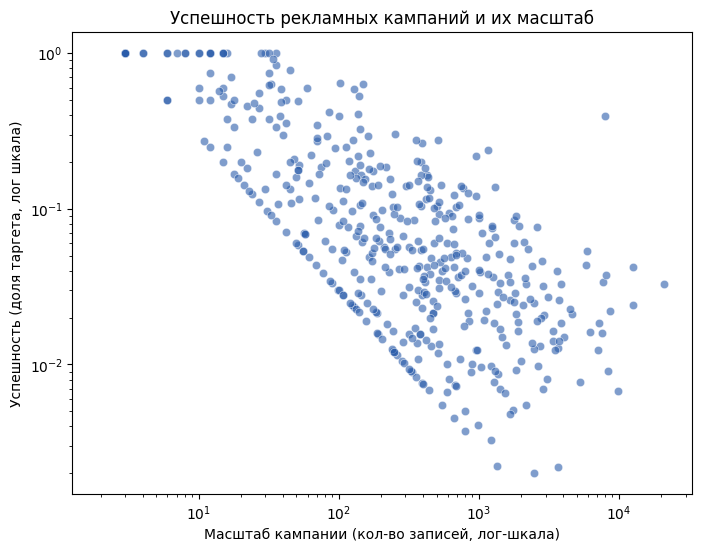

In [27]:


plt.figure(figsize=(8,6))
sns.scatterplot(
    data=target_stats,
    x='total_records', y='success_rate',
    alpha=0.6
)
plt.xscale('log') 
plt.yscale('log')
plt.title("Успешность рекламных кампаний и их масштаб")
plt.xlabel("Масштаб кампании (кол-во записей, лог-шкала)")
plt.ylabel("Успешность (доля таргета, лог шкала)")
plt.show()


***Линейная зависимость. С увеличением масштаба рекламной кампании её эффективность падает. Однако, есть несколько масштабных кампаний с высокой эффективностью***

In [28]:
target_stats = target_stats.loc[target_stats['total_records']>500].sort_values('success_rate', ascending=False)

target_stats.head(10)

,success_rate,num_success,total_records
bulk_campaign_id,,,
4981,0.3923,3139,8001
14425,0.2782,143,514
13417,0.2382,278,1167
13384,0.2173,209,962
13232,0.1418,76,536
9111,0.1408,105,746
12382,0.1390,183,1317
4860,0.1362,105,771
13004,0.1272,107,841


In [29]:
len(df['client_id'].unique())

37545

***37545 уникальных id клиентов***

In [30]:
user_stats = df.groupby('client_id')['target'].agg(['sum','mean','count']).sort_values('sum',ascending=False)
active_users = user_stats.loc[user_stats['sum']>0]
print(f"Доля активных пользовтелей: {round(len(active_users)/len(user_stats) *100,2)}%")
user_stats

Доля активных пользовтелей: 2.02%


,sum,mean,count
client_id,,,
1515915625490334876,2849,1.0000,2849
1515915625588831252,388,1.0000,388
1515915625470860261,324,1.0000,324
1515915625491750681,281,1.0000,281
1515915625489401199,247,1.0000,247
...,...,...,...
1515915626009879311,0,0.0000,12
1515915626009932400,0,0.0000,4
1515915626010079153,0,0.0000,21


<Axes: ylabel='sum'>

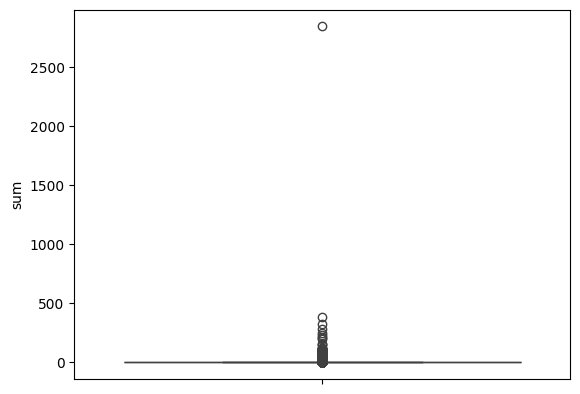

In [31]:
sns.boxplot(user_stats['sum'])


In [32]:
len(df['message_id'].unique())

44059

***В данных 44059 уникальных id сообщений***

In [33]:
len(df['cat_id'].unique())

244

***244 уникальных набора товаров***

In [34]:
print(f'Стартовая дата заказов: {df['date_purchase'].min()}')
print(f'Конечная дата заказов: {df['date_purchase'].max()}')

Стартовая дата заказов: 2022-05-16 00:00:00
Конечная дата заказов: 2024-02-16 00:00:00


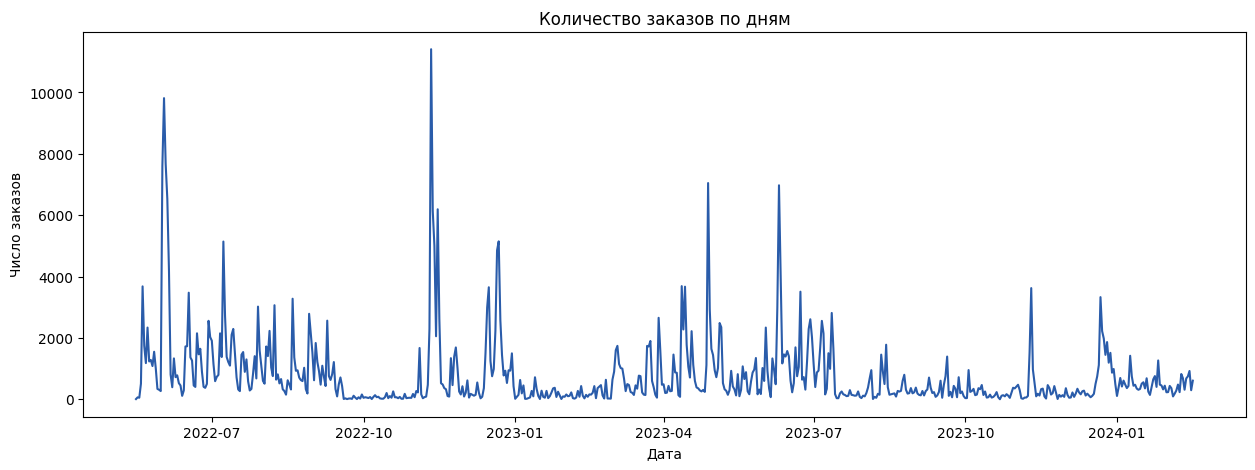

In [35]:
orders_by_day = df.groupby(df['date_purchase'].dt.date).size()

plt.figure(figsize=(15,5))
orders_by_day.plot()
plt.title("Количество заказов по дням")
plt.xlabel("Дата")
plt.ylabel("Число заказов")
plt.show()


In [36]:
print(f'Стартовая дата сообщений: {df['created_at'].min()}')
print(f'Конечная дата сообщений: {df['created_at'].max()}')

Стартовая дата сообщений: 2022-05-19 01:50:17
Конечная дата сообщений: 2024-02-15 23:51:20


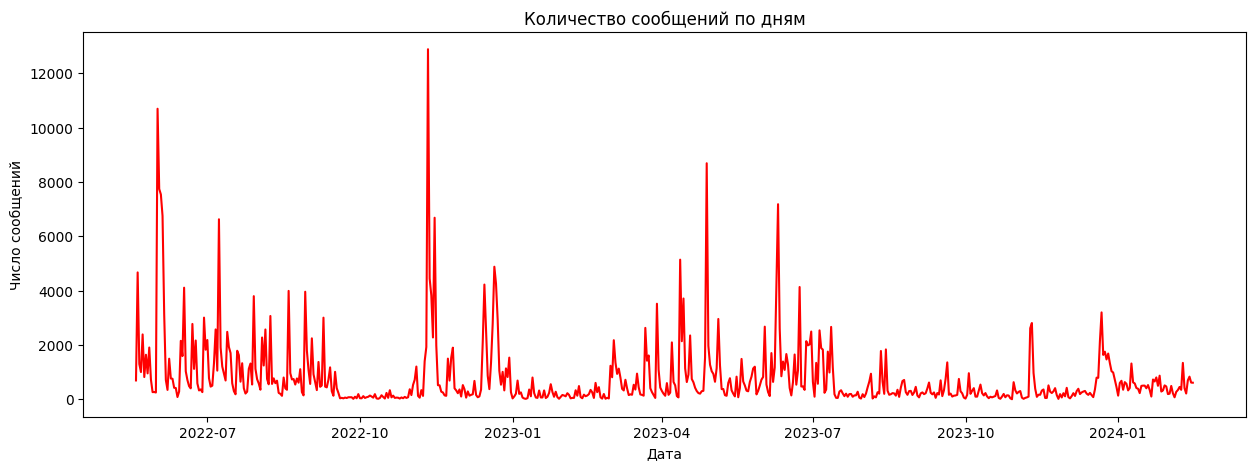

In [49]:
messages_by_day = df.groupby(df['created_at'].dt.date).size()

plt.figure(figsize=(15,5))
messages_by_day.plot(color='red')
plt.title("Количество сообщений по дням")
plt.xlabel("Дата")
plt.ylabel("Число сообщений")
plt.show()

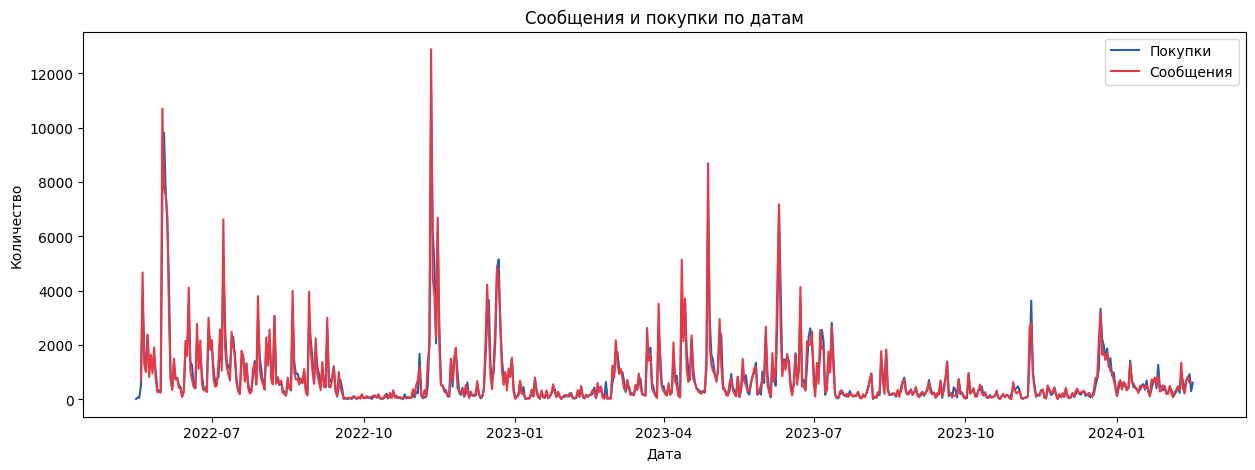

In [40]:
plt.figure(figsize=(15,5))
orders_by_day.plot(label="Покупки")
messages_by_day.plot(label="Сообщения")
plt.title("Сообщения и покупки по датам")
plt.xlabel("Дата")
plt.ylabel("Количество")
plt.legend()
plt.show()


In [41]:
print(f"Всего записей в столбце: {df['event'].shape}")
df['event'].value_counts()

Всего записей в столбце: (502125,)


event
click          173190
purchase       144177
send            94878
open            89530
hard_bounce       248
unsubscribe        69
complain           26
subscribe           7
Name: count, dtype: int64

* send — система отправила письмо

* open — «открытие» письма

* click — клик по трекаемому URL из письма.

* purchase — конверсия/покупка

* hard_bounce — постоянная недоставка: несуществующий адрес, домен, запрет приёма

* unsubscribe — пользователь отписался (по ссылке в письме или через профиль)

* complain — жалоба на спам (feedback loop от провайдера)

* subscribe — новая подписка

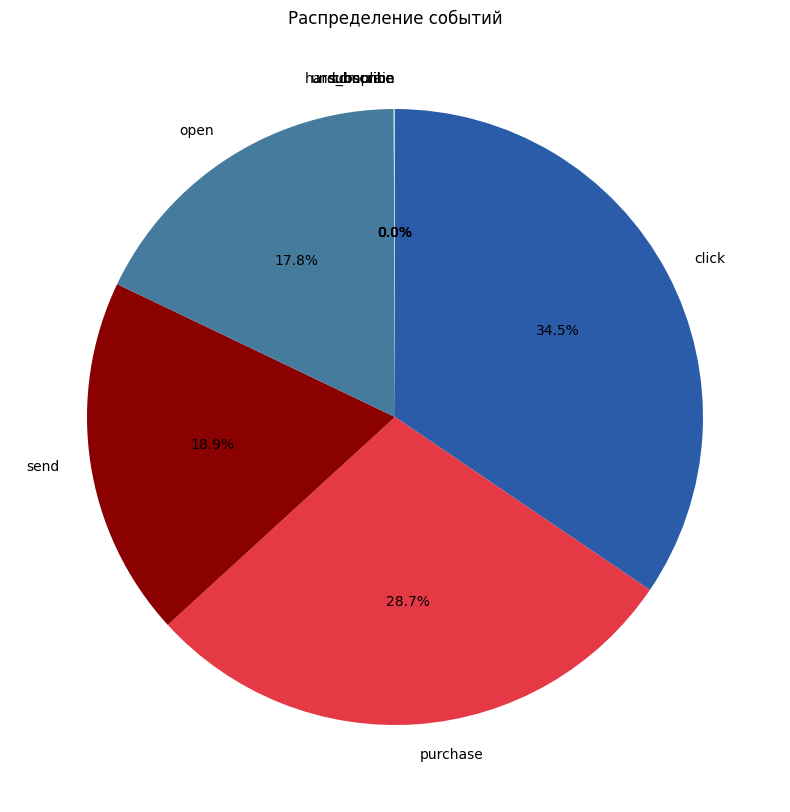

In [43]:
event_counts = df['event'].value_counts()

plt.figure(figsize=(10,10))
plt.pie(
    event_counts, 
    labels=event_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    counterclock=False
)
plt.title("Распределение событий")
plt.show()


In [44]:
df['channel'].value_counts()

channel
email          367242
mobile_push    134883
Name: count, dtype: int64

***Электронных писем почти в три раза больше, чем пуш уведомлений***

In [45]:
channel_event = pd.pivot_table(
    df,
    index='event',
    columns='channel',     
    aggfunc='size',        
    fill_value=0
)
channel_event.sort_values(by='email',ascending=False)


channel,email,mobile_push
event,,
click,132758,40432
purchase,91731,52446
open,81965,7565
send,60686,34192
unsubscribe,69,0
complain,26,0
subscribe,7,0
hard_bounce,0,248


<Figure size 1500x500 with 0 Axes>

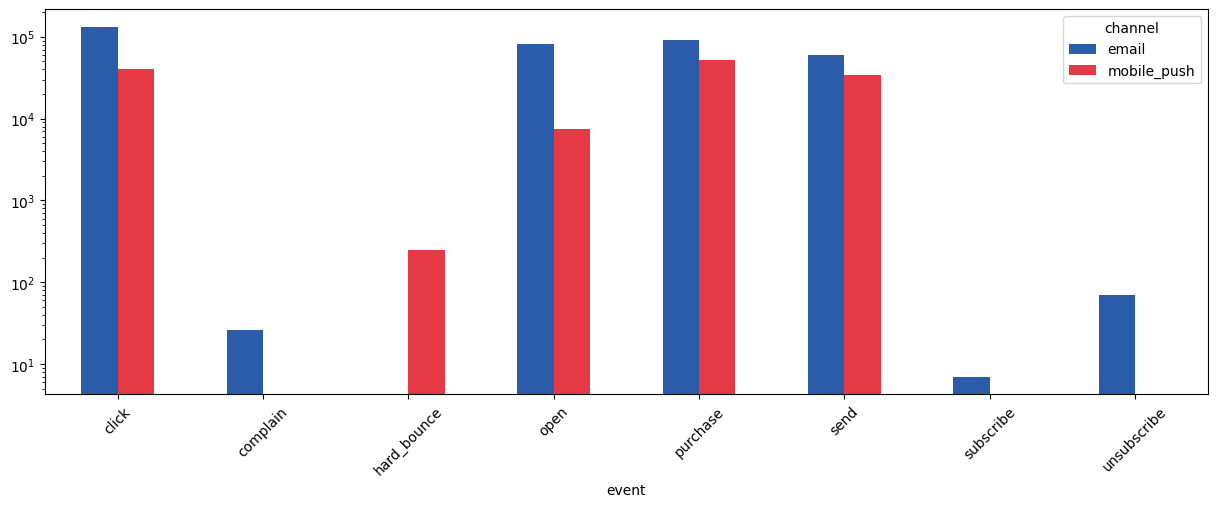

In [46]:
plt.figure(figsize=(15,5))

channel_event.plot(kind="bar", rot=45,figsize=(15,5))
plt.yscale("log")  # лог-шкала, т.к. диапазон значений большой



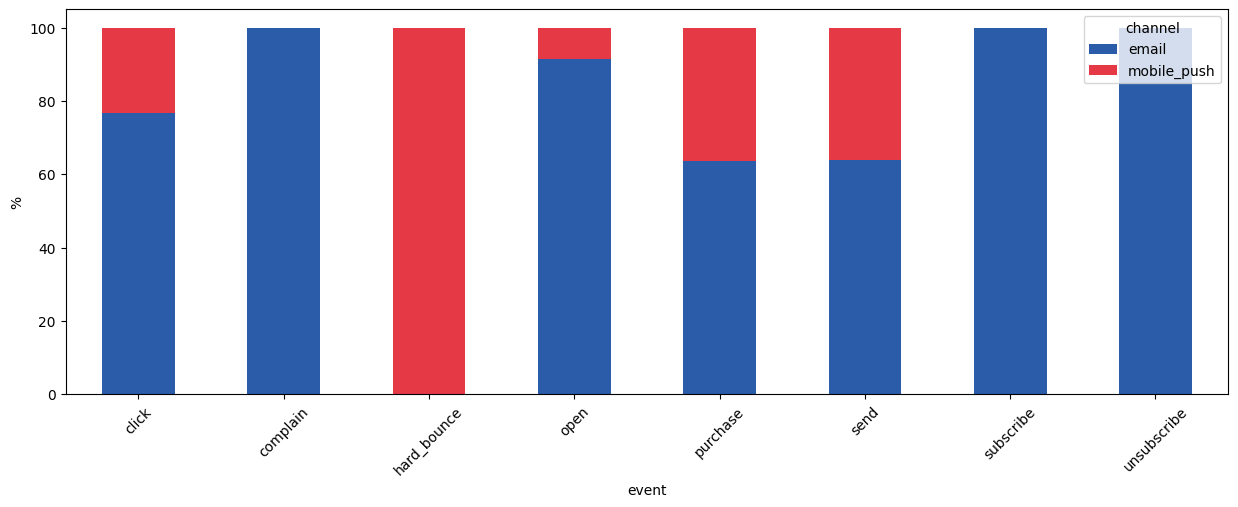

In [47]:
(channel_event.div(channel_event.sum(axis=1), axis=0) * 100).plot(kind="bar", stacked=True, rot=45,figsize=(15,5))
plt.ylabel("%")

plt.show()

In [48]:
df.head()

,client_id,quantity,price,category_ids,date_purchase,message_id,bulk_campaign_id,event,channel,date_message,created_at,target,cat_id
0,1515915625490739153,1,1999.0000,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b,4172,open,email,2022-05-27,2022-05-27 07:52:08,0,0
1,1515915625491869271,2,599.0000,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,2090,click,email,2023-04-12,2023-04-12 08:25:33,0,1
2,1515915625491869271,2,599.0000,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,2090,click,email,2023-04-18,2023-04-18 11:47:45,0,1
3,1515915625491869271,2,599.0000,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,2090,click,email,2023-06-13,2023-06-13 11:10:41,0,1
4,1515915625491869271,2,599.0000,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,2090,click,email,2023-12-28,2023-12-28 11:25:50,0,1
